In [5]:
import pandas as pd
import re
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import json

In [6]:
!pip install requests


In [7]:
# Function to scrape NASA's Global Landslide Catalog (GLC)
def scrape_landslide_data():
    url = "https://data.nasa.gov/resource/tfkf-kniw.json"  # NASA GLC API endpoint
    response = requests.get(url)
    data = response.json()
    
    landslide_data = []
    for entry in data:
        date = entry.get('event_date', 'Unknown')
        latitude = entry.get('latitude', np.nan)
        longitude = entry.get('longitude', np.nan)
        location = entry.get('country_name', 'Unknown')
        source = entry.get('source_name', 'Unknown')
        source_url = entry.get('source_link', 'Unknown')
        
        # Extract meaningful trigger factors
        raw_trigger = entry.get('trigger', 'Unknown').lower()
        if 'rain' in raw_trigger or 'storm' in raw_trigger or 'flood' in raw_trigger:
            trigger = 'Rainfall'
        elif 'earthquake' in raw_trigger or 'seismic' in raw_trigger:
            trigger = 'Earthquake'
        elif 'human' in raw_trigger or 'construction' in raw_trigger or 'mining' in raw_trigger:
            trigger = 'Human Activity'
        elif 'volcano' in raw_trigger:
            trigger = 'Volcanic Activity'
        else:
            trigger = 'Unknown'
        
        precip = float(entry.get('precip', np.random.randint(50, 1000))) if 'precip' in entry else np.random.randint(50, 1000)
        
        # Extract meaningful landslide type
        raw_landslide_type = entry.get('landslide_type', 'Unknown').lower()
        if 'debris' in raw_landslide_type or 'mudslide' in raw_landslide_type:
            landslide_type = 'Debris Flow'
        elif 'rockfall' in raw_landslide_type or 'rock slide' in raw_landslide_type:
            landslide_type = 'Rockfall'
        elif 'landslide' in raw_landslide_type or 'slump' in raw_landslide_type:
            landslide_type = 'Landslide'
        else:
            landslide_type = 'Unknown'
        
        # Assign severity based on rainfall thresholds
        if precip >= 750:
            severity = 'Severe'
        elif precip >= 300:
            severity = 'Moderate'
        else:
            severity = 'Minor'
        
        landslide_data.append({
            'date': date,
            'latitude': latitude,
            'longitude': longitude,
            'location': location,
            'source': source,
            'source_url': source_url,
            'trigger': trigger,
            'rainfall (mm)': precip,
            'landslide_type': landslide_type,
            'severity': severity
        })
    
    df = pd.DataFrame(landslide_data)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')  # Convert date column properly
    df.dropna(subset=['date'], inplace=True)  # Remove rows with invalid dates
    return df

# Function to clean and preprocess data
def clean_data(df):
    # Standardize column names
    df.columns = df.columns.str.strip().str.lower()
    
    # Convert numerical columns
    df['rainfall (mm)'] = pd.to_numeric(df['rainfall (mm)'], errors='coerce')
    df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
    df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
    
    # Convert date format
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df.dropna(subset=['date'], inplace=True)  # Remove rows with invalid dates
    
    return df

# Function to save the processed dataset
def save_processed_data(df, output_path):
    df.to_csv(output_path, index=False)
    print(f"Processed data saved to {output_path}")

# Example usage
scraped_data = scrape_landslide_data()
cleaned_dataset = clean_data(scraped_data)
save_processed_data(cleaned_dataset, 'landslide_dataset.csv')

Processed data saved to landslide_dataset.csv


In [8]:
dataset=pd.read_csv('updated_landslide_dataset.csv')

In [9]:
df=dataset

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            1000 non-null   object 
 1   latitude        1000 non-null   float64
 2   longitude       1000 non-null   float64
 3   location        1000 non-null   object 
 4   source          1000 non-null   object 
 5   source_url      1000 non-null   object 
 6   trigger         1000 non-null   object 
 7   rainfall (mm)   1000 non-null   int64  
 8   landslide_type  1000 non-null   object 
 9   severity        1000 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 78.3+ KB


In [11]:
df.shape

(1000, 10)

In [12]:
df.isnull().sum()

date              0
latitude          0
longitude         0
location          0
source            0
source_url        0
trigger           0
rainfall (mm)     0
landslide_type    0
severity          0
dtype: int64

In [13]:
df[df.isnull().any(axis=1)]

,date,latitude,longitude,location,source,source_url,trigger,rainfall (mm),landslide_type,severity


In [14]:
df.head(5)

,date,latitude,longitude,location,source,source_url,trigger,rainfall (mm),landslide_type,severity
0,2014-05-20 00:00:00,-46.7748,167.6337,New Zealand,3 News,{'url': 'http://www.3news.co.nz/Kakapo-Maggie-...,Unknown,966,Landslide,Severe
1,2010-05-29 06:45:00,-45.9034,170.0982,New Zealand,Otago Daily Times,{'url': 'http://www.odt.co.nz/news/dunedin/108...,Unknown,990,Debris Flow,Severe
2,2015-06-04 00:00:00,-45.8767,170.6273,New Zealand,Stuff.co,{'url': 'http://www.stuff.co.nz/national/69094...,Unknown,863,Debris Flow,Severe
3,2013-06-17 00:00:00,-45.8727,170.5863,New Zealand,www.radionz.co.nz,{'url': 'http://www.radionz.co.nz/news/nationa...,Rainfall,906,Landslide,Severe
4,2014-05-01 04:00:00,-45.8618,170.5090,New Zealand,3 News,{'url': 'http://www.3news.co.nz/Landslide-cras...,Unknown,681,Landslide,Moderate


In [15]:
df.tail(5)

,date,latitude,longitude,location,source,source_url,trigger,rainfall (mm),landslide_type,severity
995,2015-05-01 18:00:00,-4.1665,39.5664,Kenya,Standard Digital,{'url': 'http://www.standardmedia.co.ke/thecou...,Unknown,244,Slump,Minor
996,2015-03-18 00:00:00,-4.1380,-79.4069,Ecuador,El Comercio,{'url': 'http://www.elcomercio.com/actualidad/...,Unknown,409,Slump,Moderate
997,2009-11-10 00:00:00,-4.0666,37.7503,Tanzania,thecitizen.co,{'url': 'http://thecitizen.co.tz/newe.php?id=1...,Unknown,598,Rockfall,Moderate
998,2007-06-27 00:00:00,-4.0650,-78.9510,Ecuador,Red Cross - Field reports,{'url': 'https://www-secure.ifrc.org/dmis/prep...,Unknown,717,Landslide,Moderate
999,2014-04-30 04:30:00,-4.0602,-78.9638,Ecuador,notimerica,{'url': 'http://www.notimerica.com/sociedad/no...,Unknown,354,Mudslide,Moderate


In [16]:
df.columns

Index(['date', 'latitude', 'longitude', 'location', 'source', 'source_url',
       'trigger', 'rainfall (mm)', 'landslide_type', 'severity'],
      dtype='object')

In [17]:
columns_to_drop = ['source_url', 'source', 'location', 'date']  # Adjust if needed
df1=df.drop(columns=columns_to_drop, inplace=True)  # Modifies df directly




In [18]:
df.head(5)

,latitude,longitude,trigger,rainfall (mm),landslide_type,severity
0,-46.7748,167.6337,Unknown,966,Landslide,Severe
1,-45.9034,170.0982,Unknown,990,Debris Flow,Severe
2,-45.8767,170.6273,Unknown,863,Debris Flow,Severe
3,-45.8727,170.5863,Rainfall,906,Landslide,Severe
4,-45.8618,170.5090,Unknown,681,Landslide,Moderate


In [19]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
le = LabelEncoder()

# Encode categorical features
categorical_features = ['trigger', 'landslide_type', 'severity']
for feature in categorical_features:
    df[feature] = le.fit_transform(df[feature])

# Display transformed dataset
print(df.head())


   latitude  longitude  trigger  rainfall (mm)  landslide_type  severity
0  -46.7748   167.6337        4            966               2         2
1  -45.9034   170.0982        4            990               0         2
2  -45.8767   170.6273        4            863               0         2
3  -45.8727   170.5863        3            906               2         2
4  -45.8618   170.5090        4            681               2         1


In [20]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Select numerical columns
numerical_cols = ['latitude', 'longitude', 'rainfall (mm)']

# Apply MinMaxScaler (scaling between 0 and 1)
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])



In [21]:
df.head(5)

,latitude,longitude,trigger,rainfall (mm),landslide_type,severity
0,0.000000,0.965670,4,0.965116,2,2
1,0.020401,0.972517,4,0.990486,0,2
2,0.021026,0.973987,4,0.856237,0,2
3,0.021119,0.973873,3,0.901691,2,2
4,0.021374,0.973658,4,0.663848,2,1


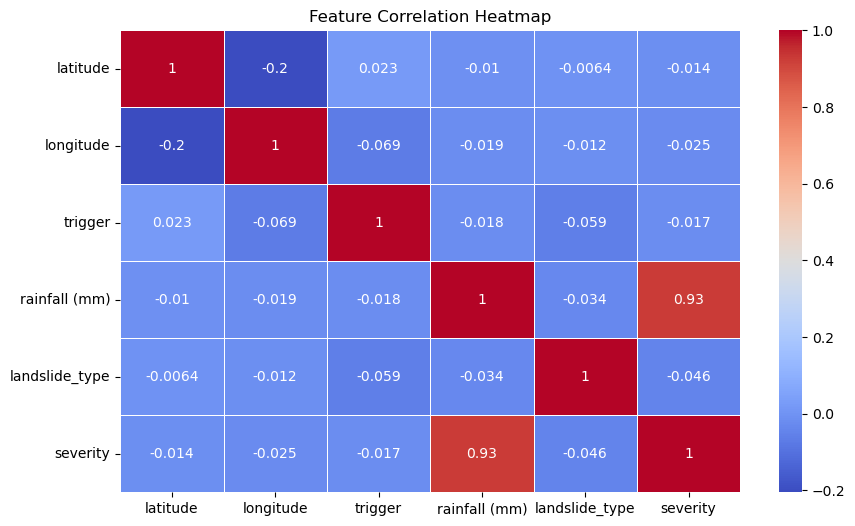

In [22]:
# Compute correlation matrix
correlation_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


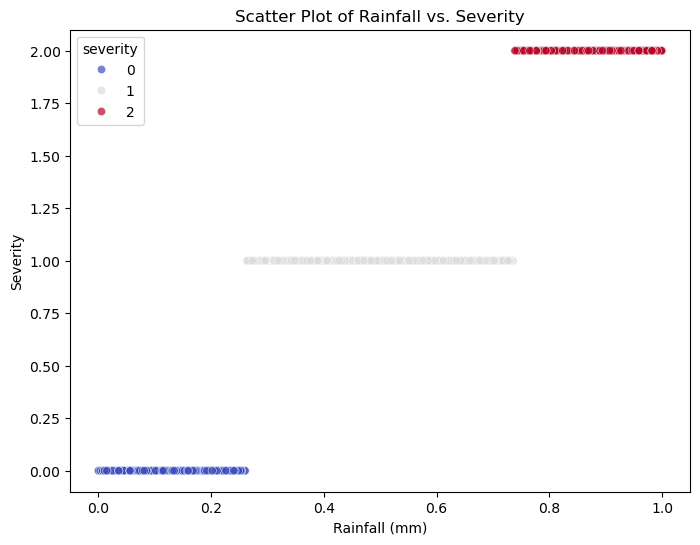

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["rainfall (mm)"], y=df["severity"], hue=df["severity"], palette="coolwarm", alpha=0.7)

plt.xlabel("Rainfall (mm)")
plt.ylabel("Severity")
plt.title("Scatter Plot of Rainfall vs. Severity")
plt.show()


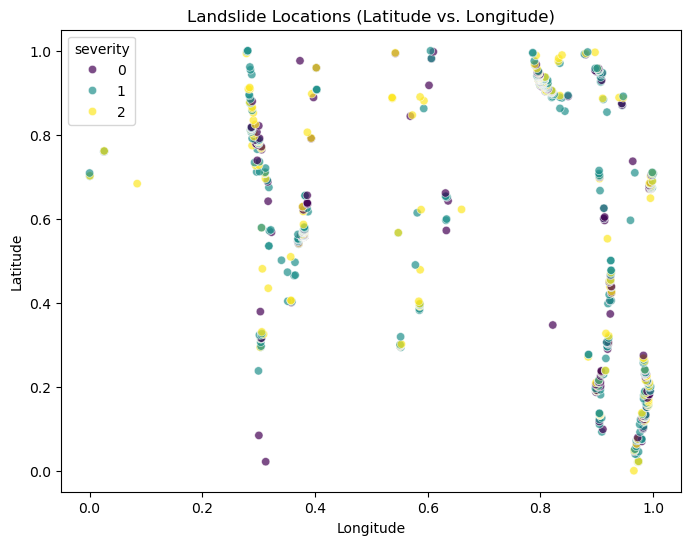

In [24]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["longitude"], y=df["latitude"], hue=df["severity"], palette="viridis", alpha=0.7)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Landslide Locations (Latitude vs. Longitude)")
plt.show()


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Splitting data
X = df.drop(columns=['severity'])  # Features
y = df['severity']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Standardizing features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Logistic Regression Model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)

# Evaluation
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Logistic Regression Accuracy: 0.984
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        63
           1       0.99      0.97      0.98       118
           2       0.97      1.00      0.99        69

    accuracy                           0.98       250
   macro avg       0.98      0.99      0.98       250
weighted avg       0.98      0.98      0.98       250



In [26]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        63
           1       1.00      1.00      1.00       118
           2       1.00      1.00      1.00        69

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250



In [27]:
from xgboost import XGBClassifier

# Train XGBoost Model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        63
           1       1.00      1.00      1.00       118
           2       1.00      1.00      1.00        69

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250



c:\Users\nagen\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:54:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
